# Standard vs. Weighted Binning

In [1]:
import numpy as np
from scipy.stats import entropy
from scipy.stats import ortho_group 
import matplotlib.pyplot as plt
np.random.seed(0)
import tensorflow as tf
import tensorflow.contrib.eager as tfe
tf.enable_eager_execution()

## 1. Hypothesis

In this notebook we try to show that the normal binning approach is not useful and try to derive a new one. 

## 2. Experiments
As before we simplify the calculation of the mutual information between the input and a representation, by just calculating the entropy of the representation (as the representation is determined by the input).

We use a very simplistic neural network model of 3 input, 3 hidden and 3 output neurons. The first weights matrix is an orthogonal matrix, such that the transposed matrix (after scaling) is the inverse matrix. We use linear activation function.

In [62]:
w1 = (1/3) * ortho_group.rvs(dim=3)
w2 = 9 * w1.T
print(w1@w2)

[[ 1.00000000e+00 -2.23155048e-17 -2.80566172e-18]
 [-1.74057426e-17  1.00000000e+00 -6.79414319e-17]
 [ 2.19160108e-19 -1.25252028e-16  1.00000000e+00]]


In [174]:
def act_fn(x):
    return x

The datapoints are randomly sampled from a normal distribution.

In [189]:
N = 1000 # number of datapoints
data = np.random.randn(3,N)
y = np.ones(N)*0.5

The bins are created with linspace between the minimum of all datavalues minus 1 and the maximum of all datavalues + 1.

In [190]:
n = 50 # number of bins
a = np.min(data)-1
b = np.max(data)+1
bins = np.tile(np.linspace(a,b,n),(3,1))

Here you can see the data points and the bins.

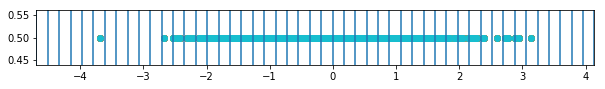

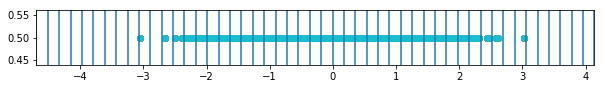

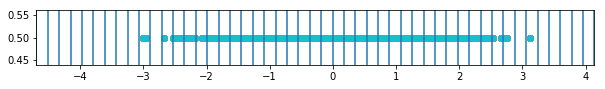

In [191]:
for i in range(bins.shape[0]):
    fig, ax = plt.subplots(1,1, figsize=(10,1), sharex=True, )
    for border in bins[i,:]:
        ax.axvline(border)
        ax.set_xlim([a,b])
        ax.scatter(data[i],y)

This function computes the entropy for certain bins. In the case that some data points will land completely outside of the bins I add one bin from the lower border to -infinity and one from the upper border to +infinity.

In [192]:
def compute_entropy(data, bins):
    digitized = []
    bins_c = np.sort(bins)
    bins_c = np.hstack([np.reshape(np.ones(3)*-np.inf,(3,1)),bins_c])
    bins_c = np.hstack([bins_c,np.reshape(np.ones(3)*np.inf,(3,1))])
    for i in range(data.shape[0]):
        dig = np.digitize(data[i,:],bins_c[i,:])
        digitized.append(dig)    
    digitized = np.array(digitized)
    uniques, unique_counts = np.unique(digitized, return_counts=True, axis=1)
    return entropy(unique_counts, base=2)

In [193]:
print("The entropy of the dataset is : {}".format(compute_entropy(data,bins)))

The entropy of the dataset is : 9.845254959649102


Entropy with standard binning of the hidden layer is: 8.03183943622959


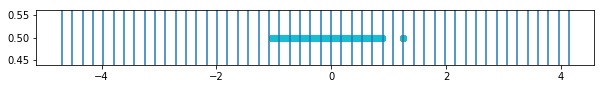

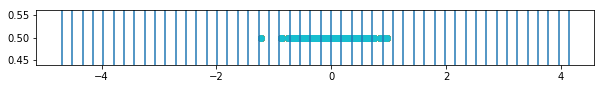

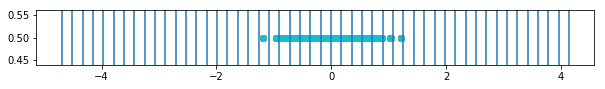

In [194]:
o1 = act_fn(w1 @ data)

for i in range(bins_ours_1.shape[0]):
    fig, ax = plt.subplots(1,1, figsize=(10,1), sharex=True, )
    for border in bins[i,:]:
        ax.axvline(border)
        ax.scatter(o1[i,:],y)
        
print("Entropy with standard binning of the hidden layer is: {}".format(compute_entropy(o1, bins)))

Entropy with standard binning of the output layer is: 9.845254959649102


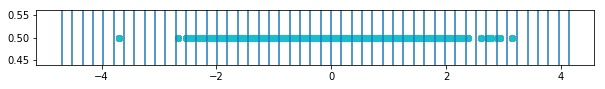

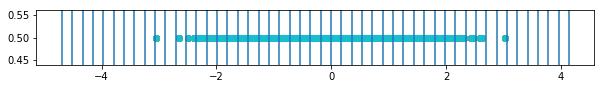

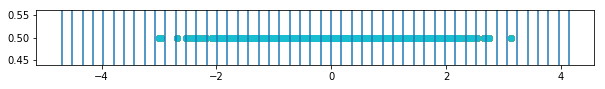

In [195]:
o2 = act_fn(w2 @ o1)

for i in range(bins_ours_1.shape[0]):
    fig, ax = plt.subplots(1,1, figsize=(10,1), sharex=True, )
    for border in bins[i,:]:
        ax.axvline(border)
        ax.scatter(o2[i,:],y)
        
print("Entropy with standard binning of the output layer is: {}".format(compute_entropy(o2, bins)))

We can see that the data processing inequality does not hold with this kind of binning. But what is wrong with it?

I the example above we constructed a network that does not lose information (transformation with invertable matrix and back). The normal binning approach cannot capture this though, because it bins always on the same scale. The scale obviously does not matter to the network as it just can rescale the values in the next layer.

This shows us that the information that is stored in a representation can not be calculated independently but is heavily dependent on what the layer afterwards can get out of it.

So let's think about what a good binning in layer K, with regard to the binning in layer K+1, should look like. First activations that are in the same bin in layer K should not lead to activations which are binned differently in layer K+1. Second activations that are in different bins in layer K should only in few cases lead to the same bins in layer K+1. Meaning this should not happen randomly, but only when the network "wants it on purpose". 

Now assume that we could find a meaningfull binning in the last layer which actually describes the few different representations that the network encodes in this layer. Then we could from there compute a "fitting" binning in the layer before and so on. T
This meaningful binning cannot be found, so we have to choose one and then propagate this through the network. In this way we make only one "false" choice for binning but do it then the same in every layer. 
To make it even easier we can do the binning on the input already and from there propagate it forward.

As this binning is dependent on the weights we will call it "weighted binning". So lets see how this works out.

In [196]:
# First forwardstep of data.
o1 = act_fn(w1 @ data)
# First forwardstep of bins. Gotta sort it as the bins might be mirrored.
#weighted_bins_1 = np.sort(act_fn( w1 @ bins ))
weighted_bins_1 = (act_fn( w1 @ bins ))

print("Entropy with weighted binning of hidden layer: {}".format(compute_entropy(o1, weighted_bins_1)))


Entropy with weighted binning of hidden layer: 9.854274509657758


In this plot we see the weighted bins (red) in comparison to the original bins (blue).

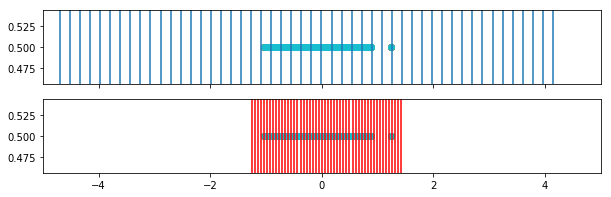

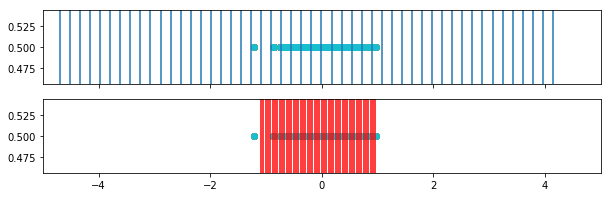

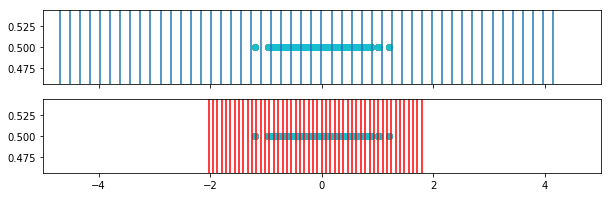

In [197]:
for i in range(weighted_bins_1.shape[0]):
    fig, ax = plt.subplots(2,1, figsize=(10,3), sharex=True, )
    for border in bins[i,:]:
        ax[0].axvline(border)
        ax[0].set_xlim([-5,5])
        ax[0].scatter(o1[i,:],y)
    for border in weighted_bins_1[i,:]:
        ax[1].axvline(border, color='r')
        ax[1].scatter(o1[i,:],y)


In [198]:
# Second forwardstep of data.
o2 = act_fn(w2 @ o1)
# Second forwardstep of bins.
#weighted_bins_2 = np.sort(act_fn( w2 @ weighted_bins_1 ))
weighted_bins_2 = (act_fn( w2 @ weighted_bins_1 ))

print("Entropy with weighted binning of output layer: {}".format(compute_entropy(o2, weighted_bins_2)))


Entropy with weighted binning of output layer: 9.845254959649102


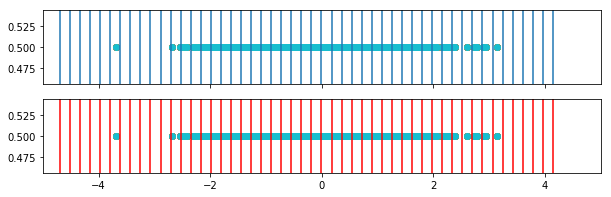

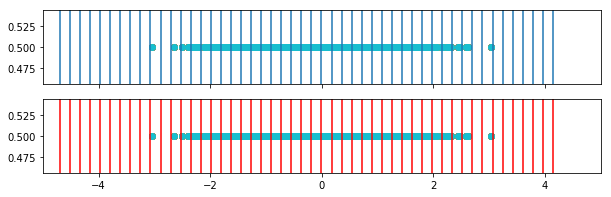

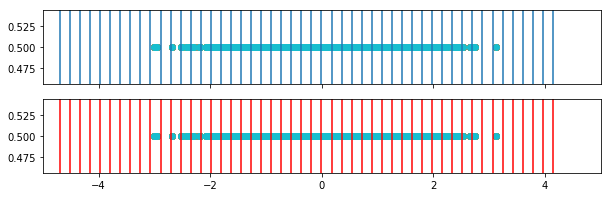

In [199]:
for i in range(weighted_bins_2.shape[0]):
    fig, ax = plt.subplots(2,1, figsize=(10,3), sharex=True, )
    for border in bins[i,:]:
        ax[0].axvline(border)
        ax[0].set_xlim([-5,5])
        ax[0].scatter(o2[i,:],y)
    for border in weighted_bins_2[i,:]:
        ax[1].axvline(border, color='r')
        ax[1].scatter(o2[i,:],y)

In [200]:
print("Entropy with standard binning is:")
print(compute_entropy(data, bins))
print(compute_entropy(o1, bins))
print(compute_entropy(o2, bins))


print("Entropy with weighted binning is:")
print(compute_entropy(data, bins))
print(compute_entropy(o1, weighted_bins_1))
print(compute_entropy(o2, weighted_bins_2))

Entropy with standard binning is:
9.845254959649102
8.03183943622959
9.845254959649102
Entropy with weighted binning is:
9.845254959649102
9.854274509657758
9.845254959649102


We see that the data processing inequality also does not hold for weighted binning but the error being made is much smaller.

Next it would be interesting to find a way to implement this into the model and see what we find there.